In [2]:
# Dependencies

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks, detrend
from scipy.fft import rfft, rfftfreq

In [ ]:
# Parameters
VIDEO_PATH = "finger.mp4"  
FPS = 30                         # Frame rate
HEART_RATE_RANGE = (0.8, 1.7)    # 48–102 bpm in Hz

In [4]:
# Load video and extract mean intensity signal
cap = cv2.VideoCapture(VIDEO_PATH)
intensity_values = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    # Convert to grayscale (you can also try red channel only)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    mean_intensity = np.mean(gray)
    intensity_values.append(mean_intensity)

cap.release()

signal = np.array(intensity_values)
time = np.arange(len(signal)) / FPS

In [5]:
# Remove DC and add highpass filter

# Detrend removes slow drift (DC component)
signal_detrended = detrend(signal)

# Highpass filter to isolate heart rate band (0.5–4 Hz ≈ 30–240 bpm)
def butter_highpass(cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

b, a = butter_highpass(0.5, FPS)
filtered_signal = filtfilt(b, a, signal_detrended)

In [ ]:
# FFT
n = len(filtered_signal)
freqs = rfftfreq(n, d=1/FPS)
fft_magnitude = np.abs(rfft(filtered_signal))

# Limit FFT to plausible heart rate frequencies (0.8–1.7 Hz)
valid_idx = np.where((freqs >= HEART_RATE_RANGE[0]) & (freqs <= HEART_RATE_RANGE[1]))[0]
peak_freq = freqs[valid_idx][np.argmax(fft_magnitude[valid_idx])]
estimated_bpm = peak_freq * 60

print(f"Estimated Heart Rate (from FFT): {estimated_bpm:.1f} bpm")

Estimated Heart Rate (from FFT): 53.4 bpm


In [43]:
from scipy.signal import find_peaks

# expected distance ~1.1s between beats; allow 0.7x slack
min_peak_distance = int(0.5 * FPS * (60 / estimated_bpm)) # expected time between heartbeats

# adaptive prominence
prom = 0.3 * np.std(filtered_signal) # How tall the peak must be compared to its surroundings

peaks, _ = find_peaks(filtered_signal,
                      distance=min_peak_distance,
                      prominence=prom)

print(f"Detected {len(peaks)} peaks (expected ~{int(estimated_bpm*len(signal)/FPS/60)})")


Detected 26 peaks (expected ~27)


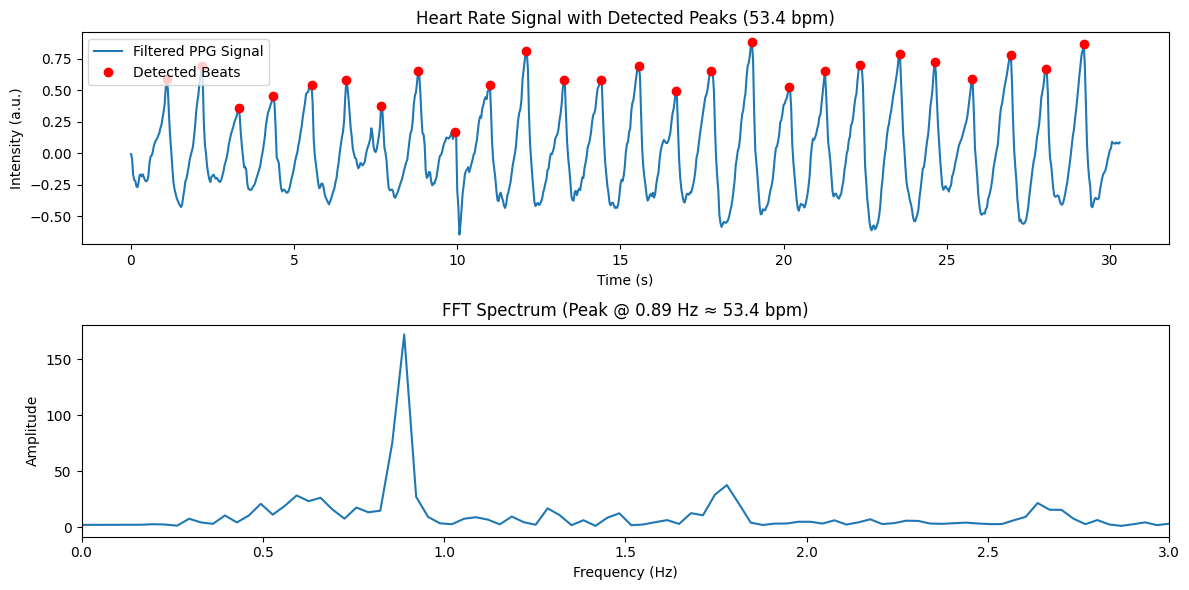

In [44]:
# Visualization

plt.figure(figsize=(12, 6))

# Time Domain Signal with Peaks
plt.subplot(2, 1, 1)
plt.plot(time, filtered_signal, label="Filtered PPG Signal")
plt.plot(time[peaks], filtered_signal[peaks], 'ro', label="Detected Beats")
plt.xlabel("Time (s)")
plt.ylabel("Intensity (a.u.)")
plt.title(f"Heart Rate Signal with Detected Peaks ({estimated_bpm:.1f} bpm)")
plt.legend()

# Plot FFT Spectrum
plt.subplot(2, 1, 2)
plt.plot(freqs, fft_magnitude)
plt.xlim(0, 3)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title(f"FFT Spectrum (Peak @ {peak_freq:.2f} Hz ≈ {estimated_bpm:.1f} bpm)")
plt.tight_layout()
plt.show()